In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import os

C:\Users\jsj31\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig

model_path = '../Model/sentiment_bert'

tokenizer = BertTokenizer.from_pretrained(model_path)
config = BertConfig.from_pretrained(model_path, output_hidden_states=True)
bert_model = BertForSequenceClassification.from_pretrained(model_path, config=config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)
bert_model.eval()

print("Loaded fine-tuned BERT from:", model_path)

Loaded fine-tuned BERT from: ../Model/sentiment_bert


In [3]:
train_data = pd.read_csv("../Dataset/train_preprocessed.csv")
texts = train_data["Phrase"].astype(str).tolist()
labels = train_data["Sentiment"].tolist()

In [4]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        encoded = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        return (
            encoded['input_ids'].squeeze(),
            encoded['attention_mask'].squeeze(),
            torch.tensor(self.labels[idx], dtype=torch.long)
        )

In [5]:
dataset = SentimentDataset(texts, labels, tokenizer)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [6]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=128, output_dim=5):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

policy_net = PolicyNetwork().to(device)

In [7]:
import json
import os

optimizer = optim.Adam(policy_net.parameters(), lr=1e-4)
epochs = 15
lambda_rl = 0.5

log_data = []

for epoch in range(epochs):
    total_loss = 0
    total_reward = 0
    total_confidence = 0
    correct_count = 0
    total_count = 0
    all_preds = []
    all_labels = []

    policy_net.train()
    for input_ids, attention_mask, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
            cls_embeddings = outputs.hidden_states[-1][:, 0, :]

        logits = policy_net(cls_embeddings)

        ce_loss = F.cross_entropy(logits, labels)

        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)
        confidence = probs[range(len(labels)), preds]
        correct = (preds == labels).float()
        reward = (correct * confidence) + ((1 - correct) * (-0.2))
        reward_loss = -reward.mean()

        loss = ce_loss + lambda_rl * reward_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_reward += reward.sum().item()
        total_confidence += confidence.sum().item()
        correct_count += correct.sum().item()
        total_count += len(labels)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    avg_reward = total_reward / total_count
    avg_confidence = total_confidence / total_count

    print(f"[Epoch {epoch+1}] Loss: {total_loss:.4f} | Accuracy: {acc:.4f} | Avg Reward: {avg_reward:.4f} | Avg Confidence: {avg_confidence:.4f}")

    log_data.append({
        "epoch": epoch + 1,
        "loss": total_loss,
        "accuracy": acc,
        "avg_reward": avg_reward,
        "avg_confidence": avg_confidence,
        "correct": correct_count,
        "total": total_count
    })

# Save training log
os.makedirs("../Logs", exist_ok=True)
with open("../Logs/supervised_rl_log.json", "w") as f:
    json.dump(log_data, f, indent=2)

print("Saved training log to ../Logs/supervised_rl_log.json")

Epoch 1: 100%|██████████| 5853/5853 [13:16<00:00,  7.35it/s]


[Epoch 1] Loss: 2622.9958 | Accuracy: 0.7210 | Avg Reward: 0.5173 | Avg Confidence: 0.7627


Epoch 2: 100%|██████████| 5853/5853 [13:30<00:00,  7.22it/s]


[Epoch 2] Loss: 2539.6180 | Accuracy: 0.7246 | Avg Reward: 0.5243 | Avg Confidence: 0.7689


Epoch 3: 100%|██████████| 5853/5853 [13:33<00:00,  7.20it/s]


[Epoch 3] Loss: 2522.3829 | Accuracy: 0.7256 | Avg Reward: 0.5258 | Avg Confidence: 0.7697


Epoch 4: 100%|██████████| 5853/5853 [13:27<00:00,  7.25it/s]


[Epoch 4] Loss: 2512.2104 | Accuracy: 0.7251 | Avg Reward: 0.5258 | Avg Confidence: 0.7699


Epoch 5: 100%|██████████| 5853/5853 [13:26<00:00,  7.25it/s]


[Epoch 5] Loss: 2504.9344 | Accuracy: 0.7250 | Avg Reward: 0.5264 | Avg Confidence: 0.7709


Epoch 6: 100%|██████████| 5853/5853 [13:25<00:00,  7.27it/s]


[Epoch 6] Loss: 2495.0341 | Accuracy: 0.7263 | Avg Reward: 0.5271 | Avg Confidence: 0.7705


Epoch 7: 100%|██████████| 5853/5853 [13:24<00:00,  7.27it/s]


[Epoch 7] Loss: 2488.8166 | Accuracy: 0.7265 | Avg Reward: 0.5280 | Avg Confidence: 0.7714


Epoch 8: 100%|██████████| 5853/5853 [13:24<00:00,  7.28it/s]


[Epoch 8] Loss: 2482.0749 | Accuracy: 0.7268 | Avg Reward: 0.5283 | Avg Confidence: 0.7714


Epoch 9: 100%|██████████| 5853/5853 [13:23<00:00,  7.28it/s]


[Epoch 9] Loss: 2474.7211 | Accuracy: 0.7270 | Avg Reward: 0.5287 | Avg Confidence: 0.7717


Epoch 10: 100%|██████████| 5853/5853 [13:22<00:00,  7.29it/s]


[Epoch 10] Loss: 2468.1641 | Accuracy: 0.7270 | Avg Reward: 0.5287 | Avg Confidence: 0.7716


Epoch 11: 100%|██████████| 5853/5853 [13:22<00:00,  7.30it/s]


[Epoch 11] Loss: 2465.8258 | Accuracy: 0.7270 | Avg Reward: 0.5289 | Avg Confidence: 0.7718


Epoch 12: 100%|██████████| 5853/5853 [13:21<00:00,  7.30it/s]


[Epoch 12] Loss: 2461.8679 | Accuracy: 0.7272 | Avg Reward: 0.5293 | Avg Confidence: 0.7723


Epoch 13: 100%|██████████| 5853/5853 [13:20<00:00,  7.31it/s]


[Epoch 13] Loss: 2453.5513 | Accuracy: 0.7279 | Avg Reward: 0.5300 | Avg Confidence: 0.7721


Epoch 14: 100%|██████████| 5853/5853 [13:21<00:00,  7.30it/s]


[Epoch 14] Loss: 2452.0173 | Accuracy: 0.7273 | Avg Reward: 0.5299 | Avg Confidence: 0.7729


Epoch 15: 100%|██████████| 5853/5853 [13:20<00:00,  7.32it/s]


[Epoch 15] Loss: 2443.0678 | Accuracy: 0.7285 | Avg Reward: 0.5307 | Avg Confidence: 0.7726
Saved training log to ../Logs/supervised_rl_log.json


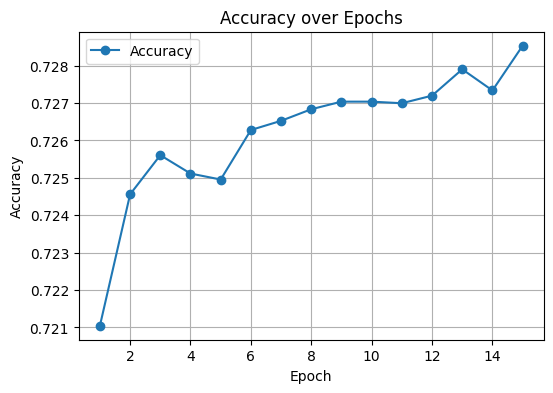

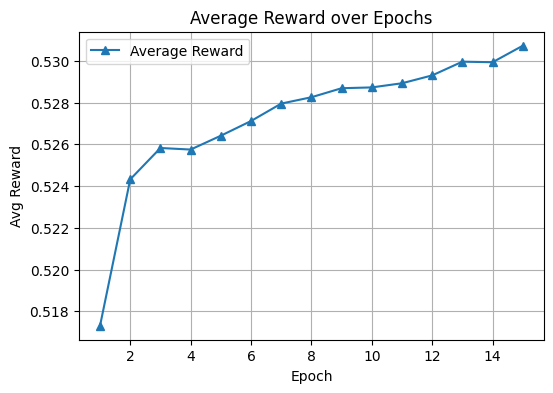

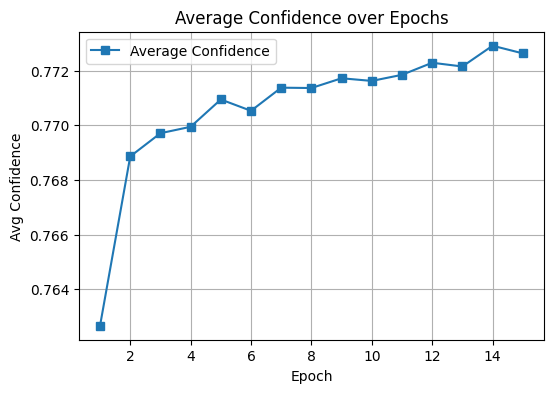

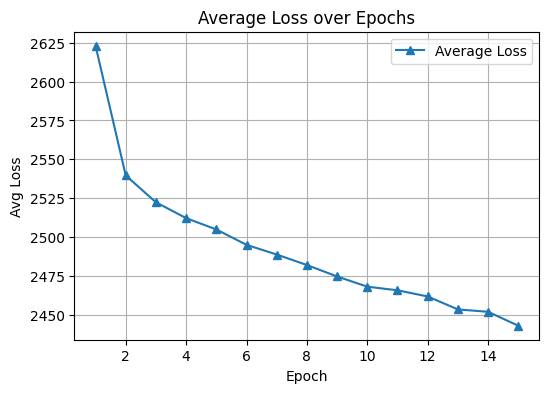

In [8]:
import matplotlib.pyplot as plt

# Data from the last training cell (mocked here for demonstration)
epochs = list(range(1, len(log_data) + 1))
losses = [entry["loss"] for entry in log_data]
accs = [entry["accuracy"] for entry in log_data]
rewards = [entry["avg_reward"] for entry in log_data]
confidences = [entry["avg_confidence"] for entry in log_data]

# Plot 1: Accuracy
plt.figure(figsize=(6, 4))
plt.plot(epochs, accs, label="Accuracy", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs")
plt.grid(True)
plt.legend()
plt.show()

# Plot 2: Average Reward
plt.figure(figsize=(6, 4))
plt.plot(epochs, rewards, label="Average Reward", marker="^")
plt.xlabel("Epoch")
plt.ylabel("Avg Reward")
plt.title("Average Reward over Epochs")
plt.grid(True)
plt.legend()
plt.show()

# Plot 3: Average Confidence
plt.figure(figsize=(6, 4))
plt.plot(epochs, confidences, label="Average Confidence", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Avg Confidence")
plt.title("Average Confidence over Epochs")
plt.grid(True)
plt.legend()
plt.show()

# Plot 2: Average Reward
plt.figure(figsize=(6, 4))
plt.plot(epochs, losses, label="Average Loss", marker="^")
plt.xlabel("Epoch")
plt.ylabel("Avg Loss")
plt.title("Average Loss over Epochs")
plt.grid(True)
plt.legend()
plt.show()

In [9]:
os.makedirs("../Model", exist_ok=True)
torch.save(policy_net.state_dict(), "../Model/policy_net_supervised.pt")
print("Saved policy_net_supervised.pt")

Saved policy_net_supervised.pt
